In [1]:
%matplotlib widget
import sys, os
import numpy as np
import pyemma as pe
import pyemma
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import mdtraj

In [2]:
sys.path.insert(0,'../')
from torchmdnet2.dataset import ChignolinDataset, DataModule
from torchmdnet2.models import LNNP, SchNet, CGnet
from torchmdnet2.utils import LoadFromFile, save_argparse
from torchmdnet2.simulation import Simulation

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

from pytorch_lightning.plugins import DDPPlugin

from torch_geometric.data import DataLoader

from torch.nn import Embedding, Sequential, Linear, ModuleList

from torchmdnet2.visualizations import (plot_trajectories_on_pes, compute_internal_coordinate_features, 
                                        project_tica, plot_tica)

In [3]:
device = torch.device('cuda')

# utils

In [4]:
from torch_geometric.data.data import size_repr

from argparse import Namespace
class Args(Namespace):
    def __init__(self,**kwargs):
        for key, item in kwargs.items():
            self[key] = item
            
    def __getitem__(self, key):
        r"""Gets the data of the attribute :obj:`key`."""
        return getattr(self, key, None)

    def __setitem__(self, key, value):
        """Sets the attribute :obj:`key` to :obj:`value`."""
        setattr(self, key, value)

    @property
    def keys(self):
        r"""Returns all names of graph attributes."""
        keys = [key for key in self.__dict__.keys() if self[key] is not None]
        keys = [key for key in keys if key[:2] != '__' and key[-2:] != '__']
        return keys

    def __len__(self):
        r"""Returns the number of all present attributes."""
        return len(self.keys)

    def __contains__(self, key):
        r"""Returns :obj:`True`, if the attribute :obj:`key` is present in the
        data."""
        return key in self.keys

    def __iter__(self):
        r"""Iterates over all present attributes in the data, yielding their
        attribute names and content."""
        for key in sorted(self.keys):
            yield key, self[key]

    def __call__(self, *keys):
        r"""Iterates over all attributes :obj:`*keys` in the data, yielding
        their attribute names and content.
        If :obj:`*keys` is not given this method will iterative over all
        present attributes."""
        for key in sorted(self.keys) if not keys else keys:
            if key in self:
                yield key, self[key]
                
    def __repr__(self):
        cls = str(self.__class__.__name__)
        has_dict = any([isinstance(item, dict) for _, item in self])

        if not has_dict:
            info = [size_repr(key, item) for key, item in self]
            return '{}({})'.format(cls, ', '.join(info))
        else:
            info = [size_repr(key, item, indent=2) for key, item in self]
            return '{}(\n{}\n)'.format(cls, ',\n'.join(info))


# load and explore the chignolin dataset

In [6]:
dataset = ChignolinDataset('/local_scratch/musil/datasets/chignolin/')

In [7]:
loader = DataLoader(dataset, batch_size=10, shuffle=True)

In [8]:
# get the prior model used to modify the forces
baseline_model = dataset.get_baseline_model()

## TICA plot of the reference trajectory

In [9]:
# compute distances all of the beads
_ = baseline_model.geom_feature(dataset.data.pos.reshape((-1, baseline_model.n_beads, 3)))
feat = baseline_model.geom_feature.distances

In [10]:
traj_ids = dataset.data.traj_idx
n_traj = np.unique(traj_ids).shape[0]
traj_strides = np.cumsum([0]+(np.bincount(traj_ids)).tolist(), dtype=int)

features = []
for i_traj in range(n_traj):
    st, nd = traj_strides[i_traj], traj_strides[i_traj+1]
    features.append(feat[st:nd].numpy())


In [11]:
tica = pe.coordinates.tica(features, lag=10, dim=2)
tica_concatenated = np.concatenate(tica.get_output())

calculate covariances:   0%|          | 0/3742 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3744 [00:00<?, ?it/s]

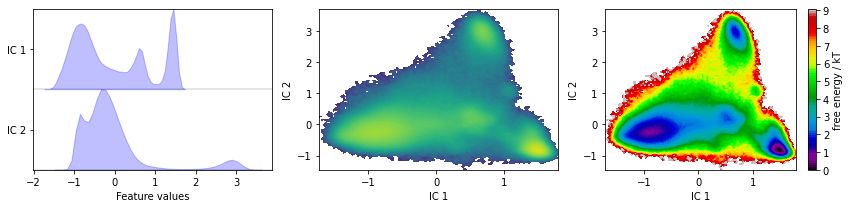

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

# train a CG model

In [8]:
args = Args(**{
    
    'batch_size': 2056,
 
    'load_model': None,
    'log_dir': '/local_scratch/musil/chign/test_0',
    
    'dataset_name': 'chignolin',
    'dataset_root': dataset.root,
    'dataset_stride' : 1,
    'target_name': 'forces',
    
    'derivative': True,
    'distributed_backend': 'ddp_spawn',
    'num_nodes': 1,
    'early_stopping_patience': 100,
    'inference_batch_size': 1024,
    'label': None,
    
    'activation': 'tanh',
    'embedding_dimension': 128,
    'cutoff_lower': 0.0,
    'cutoff_upper': 30.0,
    'num_filters': 128,
    'num_interactions': 2,
    'num_rbf': 300,
    'trainable_rbf': False,
    'rbf_type': 'gauss',
    'neighbor_embedding': True,
    'cfconv_aggr': 'mean',
    'n_layers' : 1,
    'reduction_factor' : 1,
  
    'lr': 1e-4,
    'lr_factor': 0.999,
    'lr_min': 1e-7,
    'lr_patience': 10,
    'lr_warmup_steps': 0,
    
    'ngpus': -1,
    'num_epochs': 50,
    'num_workers': 2,
    'save_interval': 10,
    'seed': 18574,
    'test_interval': 1,
    'test_ratio': 0.1,
    'val_ratio': 0.1,
    'weight_decay': 0.0,
    'precision': 32,
    
    'data' : None,
    'coords' : None,
    'forces' : None,
    'embed' : None,
    'splits' : None,
})

In [9]:
dm = DataModule(args.dataset_name, args.dataset_root, args.log_dir, args.val_ratio, args.test_ratio, 
           args.splits, args.batch_size, args.inference_batch_size, args.num_workers)

In [10]:
model = SchNet(
    hidden_channels=args.embedding_dimension,
    num_filters=args.num_filters,
    num_interactions=args.num_interactions,
    num_rbf=args.num_rbf,
    rbf_type=args.rbf_type,
    trainable_rbf=args.trainable_rbf,
    activation=args.activation,
    neighbor_embedding=args.neighbor_embedding,
    cutoff_lower=args.cutoff_lower,
    cutoff_upper=args.cutoff_upper,
    derivative=args.derivative,
    cfconv_aggr=args.cfconv_aggr,
)

In [11]:
pl.seed_everything(args.seed)


checkpoint_callback = ModelCheckpoint(
    dirpath=args.log_dir,
    monitor='validation_loss',
    save_top_k=10, # -1 to save all
    every_n_epochs=args.save_interval,
    filename="{epoch}-{val_loss:.4f}-{test_loss:.4f}"
)
early_stopping = EarlyStopping('validation_loss', patience=args.early_stopping_patience)

tb_logger = pl.loggers.TensorBoardLogger(args.log_dir, name='tensorbord', version='')
csv_logger = pl.loggers.CSVLogger(args.log_dir, name='', version='')


trainer = pl.Trainer(
    max_epochs=args.num_epochs,
    gpus=args.ngpus,
    num_nodes=args.num_nodes,
    distributed_backend=args.distributed_backend,
    default_root_dir=args.log_dir,
    auto_lr_find=False,
    resume_from_checkpoint=args.load_model,
    checkpoint_callback=True,
    callbacks=[early_stopping, checkpoint_callback],
    logger=[tb_logger, csv_logger],
    log_every_n_steps=1,
    reload_dataloaders_every_epoch=False,
    precision=args.precision,
)

Global seed set to 18574
/home/musil/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:427: UserWarning: Checkpoint directory /local_scratch/musil/chign/test_0 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/musil/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/loggers/csv_logs.py:58: UserWarning: Experiment logs directory /local_scratch/musil/chign/test_0/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


In [51]:
torch.save(model, os.path.join(args.log_dir, 'last_model.pt'))

In [19]:
checkpoint_callback.best_model_path

''

In [52]:
aa = trainer.optimizers[0]
aa.param_groups[0]['lr']

0.0001

In [12]:
aa = trainer.lr_schedulers[0]['scheduler']
aa.

In [53]:
# run test set after completing the fit
trainer.test(model)

/home/musil/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:435: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


ProcessRaisedException: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/musil/miniconda/envs/cg39/lib/python3.9/site-packages/torch/multiprocessing/spawn.py", line 59, in _wrap
    fn(i, *args)
  File "/home/musil/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/plugins/training_type/ddp_spawn.py", line 184, in new_process
    self.init_ddp_connection(self.global_rank, self.world_size)
  File "/home/musil/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/plugins/training_type/ddp_spawn.py", line 266, in init_ddp_connection
    torch.distributed.init_process_group(
  File "/home/musil/miniconda/envs/cg39/lib/python3.9/site-packages/torch/distributed/distributed_c10d.py", line 520, in init_process_group
    store, rank, world_size = next(rendezvous_iterator)
  File "/home/musil/miniconda/envs/cg39/lib/python3.9/site-packages/torch/distributed/rendezvous.py", line 199, in _env_rendezvous_handler
    store = TCPStore(master_addr, master_port, world_size, start_daemon, timeout)
RuntimeError: Address already in use


# run a simulation

In [5]:
# model = LNNP.load_from_checkpoint(
#     '/local/git/torchmd-net2/notebooks/chign_run/epoch=29-val_loss=740.0255-test_loss=0.0000.ckpt'
# )
chignolin_dataset = ChignolinDataset('/local_scratch/musil/datasets/chignolin/')

In [6]:
n_sims = 1000
n_timesteps = 10000
save_interval = 10

In [7]:
baseline_model = chignolin_dataset.get_baseline_model(n_beads=10)

In [61]:
ids = np.arange(0, len(chignolin_dataset),len(chignolin_dataset)//n_sims).tolist()
init = chignolin_dataset[ids]
initial_coords = torch.cat([init[i].pos.reshape((1,-1,3)) for i in range(len(init))], dim=0).to(device=device)
initial_coords.requires_grad_()

sim_embeddings = torch.cat([init[i].z.reshape((1,-1)) for i in range(len(init))], dim=0).to(device=device)

chignolin_net = CGnet(model, baseline_model).eval()
chignolin_net.to(device=device)

CGnet(
  (model): SchNet(hidden_channels=128, num_filters=128, num_interactions=2, num_rbf=300, rbf_type=gauss, activation=tanh, cutoff_lower=0.0, cutoff_upper=30.0, derivative=True)
  (baseline): BaselineModel(
    (geom_feature): GeometryFeature()
    (priors): Sequential(
      (0): HarmonicLayer()
      (1): HarmonicLayer()
      (2): RepulsionLayer()
    )
  )
)

In [62]:
sim = Simulation(chignolin_net, initial_coords, sim_embeddings, length=n_timesteps,
                 save_interval=save_interval, beta=baseline_model.beta,
                 save_potential=True, device=device,
                 log_interval=100, log_type='print')

traj = sim.simulate()

Generating 1001 simulations of length 10000 saved at 10-step intervals (Wed Jul 21 16:43:18 2021)
10/1000 time points saved (Wed Jul 21 16:43:38 2021)
20/1000 time points saved (Wed Jul 21 16:43:58 2021)
30/1000 time points saved (Wed Jul 21 16:44:17 2021)
40/1000 time points saved (Wed Jul 21 16:44:36 2021)
50/1000 time points saved (Wed Jul 21 16:44:57 2021)
60/1000 time points saved (Wed Jul 21 16:45:18 2021)
70/1000 time points saved (Wed Jul 21 16:45:37 2021)
80/1000 time points saved (Wed Jul 21 16:45:57 2021)
90/1000 time points saved (Wed Jul 21 16:46:16 2021)
100/1000 time points saved (Wed Jul 21 16:46:35 2021)
110/1000 time points saved (Wed Jul 21 16:46:55 2021)
120/1000 time points saved (Wed Jul 21 16:47:16 2021)
130/1000 time points saved (Wed Jul 21 16:47:36 2021)
140/1000 time points saved (Wed Jul 21 16:47:57 2021)
150/1000 time points saved (Wed Jul 21 16:48:18 2021)
160/1000 time points saved (Wed Jul 21 16:48:37 2021)
170/1000 time points saved (Wed Jul 21 16:48:56

In [ ]:
np.save('/local_scratch/musil/chign/test_4/traj.npy', traj)

# trajectory analysis

In [20]:
chignolin_dataset = ChignolinDataset('/local_scratch/musil/datasets/chignolin/')
baseline_model = chignolin_dataset.get_baseline_model(n_beads=10)

topology = mdtraj.load(chignolin_dataset.processed_paths[1])
_,_,_, cg_topology = chignolin_dataset.get_cg_mapping(topology.topology)

In [12]:
# build tica space from the training trajectory
features = compute_internal_coordinate_features(baseline_model, chignolin_dataset)
dimred_features, tica = project_tica(features, lag=10)

calculate covariances:   0%|          | 0/3742 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3744 [00:00<?, ?it/s]

In [16]:
fig, axes = plot_tica(tica, dimred_features)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [17]:
# load the simulated trajectory
traj = np.load('/local_scratch/musil/chign/test_4/traj.npy')

In [18]:
# project the trajectory on the training trajectory's tica space
features = compute_internal_coordinate_features(baseline_model, traj)
dimred_features, _ = project_tica(features, lag=10, tica=tica)

In [21]:
# check individual trajectories
plot_trajectories_on_pes(traj, dimred_features, cg_topology, start_index=0)

In [22]:
cluster = pyemma.coordinates.cluster_kmeans(tica, k=3, max_iter=50, stride=5)

initialize kmeans++ centers:   0%|          | 0/3 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

In [24]:
fig, ax, _ = pyemma.plots.plot_free_energy(*np.concatenate(dimred_features)[:, :2].T, legacy=False)
ax.scatter(*cluster.clustercenters.T, s=15, c='C1')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
cl_ids = cluster.assign(dimred_features)

In [26]:
has_transitions = []
for i_traj,assignments in enumerate(cl_ids):
    cc = np.bincount(assignments)
    if np.sum(cc != 0) > 1:
        has_transitions.append(i_traj)
print(has_transitions)

[0, 7, 10, 11, 19, 22, 26, 30, 32, 33, 39, 49, 51, 52, 53, 64, 65, 67, 73, 75, 79, 80, 86, 87, 93, 94, 95, 97, 98, 99, 103, 106, 109, 115, 125, 128, 129, 132, 136, 140, 143, 150, 152, 161, 163, 164, 167, 171, 173, 176, 178, 184, 186, 187, 189, 190, 197, 203, 209, 212, 214, 216, 222, 225, 227, 243, 247, 248, 249, 253, 254, 256, 261, 262, 265, 269, 273, 277, 279, 284, 285, 288, 290, 292, 296, 297, 304, 306, 307, 310, 317, 321, 335, 340, 341, 342, 344, 345, 348, 352, 353, 355, 356, 358, 369, 371, 373, 376, 385, 390, 394, 395, 409, 413, 414, 417, 418, 420, 424, 427, 431, 432, 436, 437, 446, 448, 452, 453, 456, 457, 462, 463, 466, 468, 469, 472, 473, 483, 485, 486, 488, 493, 494, 504, 509, 510, 514, 516, 520, 523, 528, 532, 533, 541, 542, 544, 546, 548, 550, 551, 558, 560, 562, 564, 565, 575, 578, 586, 597, 603, 604, 605, 619, 620, 623, 624, 626, 630, 632, 651, 652, 655, 657, 658, 665, 668, 670, 672, 678, 681, 696, 697, 698, 700, 710, 713, 716, 717, 720, 721, 723, 727, 732, 733, 737, 739, 7